In [1]:
import sys
from data import RecordStore, Record
import numpy as np
from typing import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
import matplotlib.pyplot as plt


In [2]:
RecordStore.load()
RecordStore.load_w2v()

len(RecordStore.classes), RecordStore.classes

(15,
 ['P', 'D', 'Q', 'K', 'E', 'H', 'F', 'T', 'S', 'R', 'G', 'B', 'N', 'L', 'J'])

In [28]:
class LSTM_Classifier(torch.nn.Module):
    def __init__(self) -> None:
        super(LSTM_Classifier, self).__init__()
        num_layers = 2
        dropout = 0.1
        hidden_size = 300
        # h0 = torch.randn(num_layers, batch_size, hidden_size)
        # c0 = torch.randn(num_layers, batch_size, hidden_size)
        self.lstm_title = torch.nn.LSTM(input_size=300, hidden_size=hidden_size,
            num_layers=num_layers, dropout=0.1, batch_first=True).cuda()
        self.lstm_synopsis = torch.nn.LSTM(input_size=300, hidden_size=hidden_size, 
            num_layers=num_layers, dropout=0.1, batch_first=True).cuda()
        self.clf = nn.Sequential(nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, len(RecordStore.classes))
            ).cuda()

    def _get_last_timesteps(self, lstm_out):
        padded_seq, lengths = rnn.pad_packed_sequence(lstm_out, batch_first=True)
        last_timesteps = []
        for i in range(len(padded_seq)):
            last_timesteps.append(padded_seq[i, lengths[i]-1])
        return torch.stack(last_timesteps, dim=0)

    def forward(self, x_t, x_s):
        lstm_out_t, _ = self.lstm_title(x_t)
        lstm_out_s, _ = self.lstm_synopsis(x_s)
        last_timesteps_t = self._get_last_timesteps(lstm_out_t)
        last_timesteps_s = self._get_last_timesteps(lstm_out_s)
        # print('lts shapes:', last_timesteps_t.shape, last_timesteps_s.shape)
        clf_out = self.clf(torch.concat([last_timesteps_t, last_timesteps_s], dim=1))
        scores = F.log_softmax(clf_out, dim=1)
        return scores
    
    def predict(self, x_t, x_s):
        assert type(x_t) == type(x_s) == torch.Tensor, "expected a single tensor"
        assert len(x_t.shape) == len(x_s.shape) == 2, "expected a tensor with 2 dimensions"
        x_t, x_s = rnn.pack_sequence([x_t]), rnn.pack_sequence([x_s])
        out = self.forward(x_t, x_s).squeeze(0)
        return torch.argmax(out)

In [23]:
X_t, X_s, Y = [], [], []
for record in RecordStore.train_records:
    X_t.append(torch.from_numpy(record.title_embeddings_w2v).cuda())
    X_s.append(torch.from_numpy(record.synopsis_embeddings_w2v).cuda())
    Y.append(record.cls_idx)

In [24]:
def sort_XXY(X_t, X_s, Y):
    to_be_sorted = [(x_t, x_s,y) for x_t, x_s,y in zip(X_t, X_s, Y)]
    to_be_sorted.sort(reverse=True, key=lambda x: x[1].shape[0])
    X_t, X_s, Y = [], [], []
    for (x_t, x_s, y) in to_be_sorted:
        X_t.append(x_t)
        X_s.append(x_s)
        Y.append(y)
    return X_t, X_s, Y

X_t, X_s, Y = sort_XXY(X_t, X_s, Y)
Y = torch.tensor(Y).cuda()

In [25]:
def accuracy(model: nn.Module, X_t, X_s, Y):
    mode = model.training
    model.eval()
    count = 0
    with torch.no_grad():
        for x_t, x_s, y in zip(X_t, X_s, Y):
            if model.predict(x_t, x_s) == y:
                count += 1
    print('count, len:', count, len(X_t))
    model.train(mode)
    return count / len(X_t)

In [29]:
model = LSTM_Classifier().cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.NLLLoss()

In [30]:
# Training
losses = []
batch_size = 64
for epoch in range(30):
    print('epoch:', epoch)
    n_steps = int(len(X_s)/batch_size)
    for i in range(n_steps):
        inp_t = rnn.pack_sequence(X_t[i*batch_size:(i+1)*batch_size], enforce_sorted=False)
        inp_s = rnn.pack_sequence(X_s[i*batch_size:(i+1)*batch_size])
        labels = Y[i*batch_size:(i+1)*batch_size]
        model.zero_grad()
        out = model(inp_t, inp_s)
        # print('out shape')
        # print(out.shape)
        loss = loss_function(out, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()

        if i % 100 == 0:
            print('{}/{}'.format(i, n_steps))
            print('loss:{}'.format(loss.item()))


epoch: 0
0/398
loss:2.7003345489501953
100/398
loss:1.6959142684936523
200/398
loss:1.3726681470870972
300/398
loss:1.62528395652771
epoch: 1
0/398
loss:3.6495959758758545
100/398
loss:0.9839960932731628
200/398
loss:0.9477501511573792
300/398
loss:1.181134581565857
epoch: 2
0/398
loss:1.6717195510864258
100/398
loss:0.8923726677894592
200/398
loss:0.7188261151313782
300/398
loss:0.8727366328239441
epoch: 3
0/398
loss:1.0477486848831177
100/398
loss:0.5940463542938232
200/398
loss:0.626224160194397
300/398
loss:0.7104747295379639
epoch: 4
0/398
loss:0.7386025786399841
100/398
loss:0.6340188384056091
200/398
loss:0.5155888795852661
300/398
loss:0.616891622543335
epoch: 5
0/398
loss:0.5868100523948669
100/398
loss:0.39343756437301636
200/398
loss:0.4527129530906677
300/398
loss:0.5089768767356873
epoch: 6
0/398
loss:0.4022226929664612
100/398
loss:0.38621246814727783
200/398
loss:0.2633793354034424
300/398
loss:0.31388863921165466
epoch: 7
0/398
loss:0.35230299830436707
100/398
loss:0.34

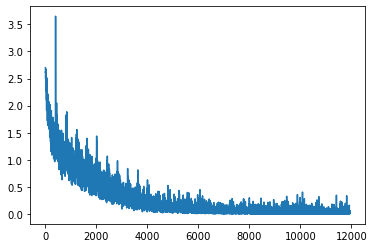

In [31]:
plt.plot(losses)

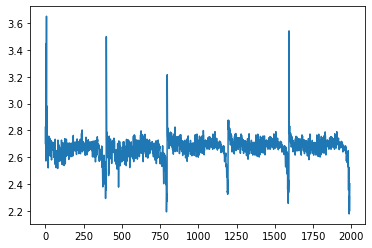

In [12]:
# an old loss
plt.plot(losses)

In [32]:
accuracy(model, X_t, X_s, Y)

count, len: 25312 25526


0.991616391130612

In [33]:
# Prepare test data
X_t_test, X_s_test, Y_test = [], [], []
for record in RecordStore.test_records:
    X_t_test.append(torch.from_numpy(record.title_embeddings_w2v).cuda())
    X_s_test.append(torch.from_numpy(record.synopsis_embeddings_w2v).cuda())
    Y_test.append(record.cls_idx)

In [34]:
accuracy(model, X_t_test, X_s_test, Y_test)

count, len: 2153 3000


0.7176666666666667

In [35]:
torch.save(model, 'model1.pt')